In [1]:
import pandas as pd
import numpy as np
from obfuscator import comment_remover, variable_renamer
from csv_stuff import create_labled_table_routine, add_valid_code_columns, remove_given_code
import sys
# sys.path.append('/home/erik/TU/ni/Source-Code-Plagiarism-Detection/Source codes/')
sys.path.append('../../../Source-Code-Plagiarism-Detection/Source codes/')
from remove_given_code_from_student_solution import remove_given_code_from_df


PATH_TEMPLATE = "/home/erik/TU/ni/plagiate_labeltool/data/code_templates/"


def create_plagiate_table(df, semester, ha, task, prog_language, number_labled_pairs, path):
    df_labled = pd.DataFrame(columns=['semester', 'ha', 'task', 'prog_lang',
                                      'surname1', 'lastname1', 'code1', 'code2', 'label'])

    df = add_valid_code_columns(df, semester, ha, [task], prog_language)
    number_of_valid_codes = len(df.loc[df[f'{task} empty'] == 0])
    print("number_of_valid_codes: " + str(number_of_valid_codes))
    plagiate_per_solution = int(np.floor(number_labled_pairs/number_of_valid_codes))
    print("plagiate_per_solution: " + str(plagiate_per_solution))
    for ln, sn, code in df.loc[df[f'{task} empty'] == 0][['Nachname', 'Vorname', task]].values:
        for i in range(plagiate_per_solution):
            plagiate_code = comment_remover(code)
            plagiate_code = variable_renamer(plagiate_code)
            df_labled.loc[len(df_labled)] = [
                semester, ha, task, prog_language, sn, ln, code, plagiate_code, 1]
    df_labled.to_csv(path)
    return df_labled


def create_plagiate_table_routine(semester, ha, task, prog_language):
    csv_path = f'../../data/raw_data/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten.csv'
    csv_path1 = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_removed_preload.csv'
    # csv_path1 = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_labled.csv'
    csv_path2 = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_plagiate.csv'
    df = pd.read_csv(csv_path, delimiter=',')
    number_labled_pairs = len(pd.read_csv(csv_path1, delimiter=','))
    df_labled = create_plagiate_table(
        df, semester, ha, task, prog_language, number_labled_pairs, csv_path2)
    return df_labled


def create_plagiate_table_from_df(df, semester, ha, prog_language):
    save_path = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_plagiate.csv'
    number_labled_pairs = len(df)
    df = df.drop_duplicates(subset=['surname1'])
    number_of_valid_codes = len(df)
    print("number_of_valid_codes: " + str(number_of_valid_codes))
    print("number_labled_pairs: " + str(number_labled_pairs))
    plagiate_per_solution = int(np.floor(number_labled_pairs/number_of_valid_codes))
    print("plagiate_per_solution: " + str(plagiate_per_solution))
    # drop unnecessary columns
    df = df.drop(columns=['hand_labled', 'Unnamed: 0', 'surname2', 'lastname2'])
    # duplicate each row of df1 plagiate_per_solution times and create new column code2 and use the field code1 as input value for the functions comment_remover and variable_renamer
    df = df.reindex(df.index.repeat(plagiate_per_solution))
    df['code2'] = df['code1'].apply(comment_remover)
    df['code2'] = df['code2'].apply(variable_renamer)
    df['label'] = 1
    df.to_csv(save_path)
    return df


def split_data_from_labled(semester, ha, prog_language):
    df_labled = pd.read_csv(f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_labled.csv', delimiter=',')
    df_labled = remove_given_code_from_df(df_labled)
    df_plagiate = create_plagiate_table_from_df(df_labled, semester, ha, prog_language)
    return df_plagiate
    

def open_csvs(semester, ha, prog_language):
    original_csv_path = f'../../data/raw_data/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten.csv'
    labled_csv_path = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_removed_preload.csv'
    plagiate_csv_path = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_plagiate.csv'
    df_original = pd.read_csv(original_csv_path, delimiter=',')
    df_labled = pd.read_csv(labled_csv_path, delimiter=',')
    return df_original, df_labled, plagiate_csv_path


In [2]:
semester='SoSe22'
ha='9'
task='Antwort 9'
prog_language='C'
# path = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_plagiate.csv'
path = f'../../data/labled/PPR [{semester}]-{ha}. Hausaufgabe - Pflichttest {prog_language}-Antworten_labled_angefangen.csv'

In [3]:
# df_plagiate = split_data_from_labled(semester, ha, prog_language)

Index(['semester', 'ha', 'task', 'prog_lang', 'surname1', 'lastname1',
       'surname2', 'lastname2', 'code1', 'code2', 'label', 'hand_labled'],
      dtype='object')
0.5196301884602565


<AxesSubplot: >

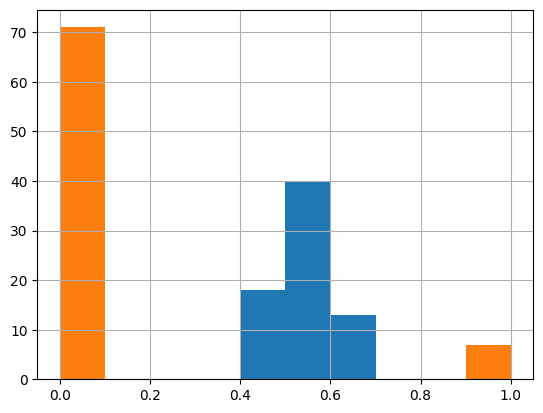

In [4]:
def remove_specific_students(df_labled, names):
    for name in names:
        df_labled = df_labled.drop(df_labled[(df_labled['lastname1'] == name) | (df_labled['lastname2'] == name)].index)
    return df_labled


df_labled = pd.read_csv(path)
try:
    df_labled = df_labled.drop(columns=['Unnamed: 0'])
except KeyError:
    pass
print(df_labled.columns)
names = ['Lehmann', 'Hengst', 'Hilger', 'Krause']
df_labled = remove_specific_students(df_labled, names)

print(df_labled['label'].mean())
df_labled['label'].hist()
df_labled['hand_labled'].hist()
# df_labled.to_csv(path, index=False)
# vorgabe entfernen, auto labeln lassen und dann plagiate erstellen

In [5]:
import re
def striphtml(data): 
    return re.sub('<.*?>', ' ', str(data)) 

def stripunc(data): 
    return re.sub('[^A-Za-z%\._\[\]]+', ' ', str(data), flags=re.MULTILINE|re.DOTALL) 

In [6]:
# # for prasentation to show example strip
# read_path='/home/erik/TU/ni/plagiarism_detection_tool/data/labled/handmade_plagiate_0_0.c'
# write_path='/home/erik/TU/ni/plagiarism_detection_tool/data/labled/handmade_plagiate_0_3.c'
# with open(read_path, 'r') as file:
#     code = file.read()
#     code = striphtml(stripunc(code))
#     with open(write_path, 'w') as file:
#         file.write(code)

## Swap C loops

In [23]:
given_string = 'for (int i = 0; i < 10; i++){\n\tprintf("%d", i);\n}\nint abc = 0;\nwhile (abc < 10){\n\tprintf("%d", abc);\n\tabc++;\n}'
print(given_string)
print(swap_loops_type(given_string))

for (int i = 0; i < 10; i++){
	printf("%d", i);
}
int abc = 0;
while (abc < 10){
	printf("%d", abc);
	abc++;
}
for 0
while 63
int i = 0;
while (i < 10){
	printf("%d", i);
	i++;
}
int abc = 0;
for (; abc < 10; abc++){
	printf("%d", abc);
}


In [35]:
import re

def remove_comments(text, regexs = ["//[\t  \S]*", "/\*[\s\S]*?\*/"]):
    tmp = text
    for regex in regexs :
        all_matches = re.findall(regex,tmp)
        for match in all_matches:
            tmp = tmp.replace(match, "")
    return tmp


def swap_loops_type(given_string):
    matches = [(x.group(), x.start(0)) for x in re.finditer(r'for|while', given_string)]
    for match, index in matches:
        if match == 'for':
            given_string = given_string[:index] + for_to_while(given_string[index:])
        elif match == 'while':
            given_string = given_string[:index] + while_to_for(given_string[index:])
    return given_string

# call this function without opening curly braces in substring
def idx_closing_brace(given_substring):
    sum_braces = 1
    for i, char in enumerate(given_substring):
        if char == '{':
            sum_braces += 1
        elif char == '}':
            sum_braces -= 1
        if sum_braces == 0:
            return i
    return -1


def for_to_while(given_string):
    pattern = '\n*(\s*)for\s*\((.*?;)(.*?)(;.*?)\)(\s*{+)*'
    # find first match of pattern in string
    matches = re.findall(pattern, given_string)
    
    # get all end indexes of all matches of pattern in string
    indexes = [x.end(0) for x in re.finditer(pattern, given_string)]
    # split for loop into 3 parts and pre-spaces
    for index,(spaces, init, cond, incr, open_brace) in zip(indexes, matches):
        pattern_tmp = 'for\s*\(' + re.escape(''.join([init, cond, incr])) + '\)(\s*{+)*'
        cond = cond.strip()
        # remove ';' at the beginning and add it at the end of the of the third part
        incr = incr[1:].strip()
        incr = incr + ';'
        idx_brace = idx_closing_brace(given_string[index+1:])
        init_line = init + '\n' + spaces if init != ';' else ''
        if idx_brace == -1:
            # insert necessary braces
            if incr != ';':
                given_string = given_string[:index] + re.sub(';', ';\n\t' + spaces + incr + '\n' + spaces + '}', given_string[index:], 1)
            given_string = re.sub(pattern_tmp, init_line + 'while (' + cond + '){', given_string, 1)
        else:
            # add missing offset from index+1
            idx_brace += index+1
            if incr != ';':
                given_string = given_string[:idx_brace] + re.sub('}', '\t' + incr + '\n' + spaces + '}', given_string[idx_brace:], 1)
            given_string = re.sub(pattern_tmp, init_line + 'while (' + cond + ')' + open_brace, given_string, 1)
    return given_string


# does not work with do while loops
def while_to_for(given_string):
    pattern = 'while\s*\((.*?)\)(\s*{+)*(?:(?:.|\n)*?)\s*(.*;)\s*}'
    pattern_braces = 'while\s*\((.*?)\)(\s*{+)*'
    matches = re.findall(pattern, given_string)
    indexes = [x.end(0) for x in re.finditer(pattern_braces, given_string)]
    for index,(cond, open_brace, incr) in zip(indexes, matches):
        pattern_tmp = 'while\s*\(' + re.escape(cond) + '\)(\s*{+)*'
        cond = cond.strip()
        if incr != '':
            given_string = re.sub(';\s*' + re.escape(incr), ';', given_string, 1)
            incr = ' ' + incr[:-1].strip()
        idx_brace = idx_closing_brace(given_string[index+1:])
        if idx_brace == -1:
            continue
        # add missing offset from index+1
        idx_brace += index+1
        given_string = re.sub(pattern_tmp, 'for (; ' + cond + ';' + incr + ')' + open_brace, given_string, 1)
    return given_string

In [8]:
def mirror_logic(logic):
    match logic:
        case '<':
            return '>'
        case '>':
            return '<'
        case '<=':
            return '>='
        case '>=':
            return '<='
        case _:
            return logic

# swap variables in logic equations like a <= b to b >= a
def mirrow_simple_logic_equations(given_string):
    pattern = '\s*([^;()]+?)\s*(!=|==|\|\||&&|<=|>=|<|>)\s*([^;()]+)'
    indexes = [(x.start(1),x.end(0)) for x in re.finditer(pattern, given_string)]
    matches = re.findall(pattern, given_string)
    for (start, end), (a, logic, b) in zip(indexes, matches):
        if 'include' in a or 'define' in a: # is a workaround for the problem that the pattern matches also in #include <stdio.h>
            continue
        given_string = given_string[:start] + f'{b.strip()} {mirror_logic(logic)} {a.strip()}' + given_string[end:]
    return given_string

def mirrow_nested_logic_equations(given_string):
    pass #([\S()]+)\s*(!=|==|\|\||&&|<=|>=|<|>)\s*([\s()]+)


In [11]:
def invert_logic(logic):
    match logic:
        case '<=':
            return '>'
        case '>=':
            return '<'
        case '<':
            return '>='
        case '>':
            return '<='
        case '==':
            return '!='
        case '!=':
            return '=='
        case '&&':
            return '||'
        case '||':
            return '&&'
        case _:
            return logic

def demorgan_on_equations(given_string):
    pattern = '\(((?:[;()\S ]+?)\s*(!=|==|\|\||&&|<=|>=|<|>)\s*(?:[()\S ;]+))\)'
    indexes = [(x.start(0),x.end(0)) for x in re.finditer(pattern, given_string)]
    matches = re.findall(pattern, given_string)
    for (start, end), (match, logic) in zip(indexes, matches):
        given_string = given_string[:start] + re.sub(re.escape(match), f'!({match.replace(logic, invert_logic(logic))})', given_string[start:], count=1) 
    return given_string


## Testcases

In [34]:
given_string2 = 'for (int i = 0; i < 10; i++){\n\tfor (int j = 0; j < 10; j++){\n\t\tint alpha=0;\n\t\twhile(alpha<3){\n\t\t\tprintf("%d", i);\n\t\t\talpha++;\n\t\t}\n\t}\n}'
print(given_string2)
print(swap_loops_type(given_string2))
print('int i = 0;\nwhile (i < 10){\n\tint j = 0;\n\twhile (j < 10){\n\t\tint alpha=0;\n\t\tfor(;alpha<3; alpha++){\n\t\t\tprintf("%d", i);\n\t\t}\n\t}\n}')


for (int i = 0; i < 10; i++){
	for (int j = 0; j < 10; j++){
		int alpha=0;
		while(alpha<3){
			printf("%d", i);
			alpha++;
		}
	}
}


TypeError: 'int' object is not iterable

In [42]:
import unittest

# TODO rewrite test functions to test subclasses
# TODO tests all edge cases, because students dont write good code
# TODO for_to_while wird \0 nicht richtig ersetzt/verschoben (Null)
# import pdb; pdb.set_trace() # debug
class Test(unittest.TestCase):
    given_string = 'for (int i = 0; i < 10; i++){\n\tprintf("%d", i);\n}\nint abc = 0;\nwhile (abc < 10){\n\tprintf("%d", abc);\n\tabc++;\n}'
    given_string2 = 'for (int i = 0; i < 10; i++){\n\tfor (int j = 0; j < 10; j++){\n\t\tint alpha=0;\n\t\twhile(alpha<3){\n\t\t\tprintf("%d", i);\n\t\t\talpha++;\n\t\t}\n\t}\n}'
    given_string3 = 'for (int i = 0; i < 10; i++){\n\tprintf("%d", i);\n}'

    def test_remove_comments(self):
        self.assertEqual(remove_comments(self.given_string), self.given_string)
        comment_string = '// Funktion die bis 100 zählt\nfor (int i = 0; i < 10; i++){\n\t/* zweite Schleife\n\t   damit wird 10*10 gerechnet */\n\tfor (int j = 0; j < 10; j++){\n\t\tprintf("%d", i);\t// das ist ein printf\n\t}\n}'
        self.assertEqual(remove_comments(comment_string), '\nfor (int i = 0; i < 10; i++){\n\t\n\tfor (int j = 0; j < 10; j++){\n\t\tprintf("%d", i);\t\n\t}\n}')

    def test_swap_loops_type(self):
        self.assertEqual(swap_loops_type(self.given_string), 'int i = 0;\nwhile (i < 10){\n\tprintf("%d", i);\n\ti++;\n}\nint abc = 0;\nfor (; abc < 10; abc++){\n\tprintf("%d", abc);\n}')
        self.assertEqual(swap_loops_type(self.given_string2), 'int i = 0;\nwhile (i < 10){\n\tint j = 0;\n\twhile (j < 10){\n\t\tint alpha=0;\n\t\tfor(;alpha<3; alpha++){\n\t\t\tprintf("%d", i);\n\t\t}\n\t}\n}')
        self.assertEqual(swap_loops_type(self.given_string3), 'int i = 0;\nwhile (i < 10){\n\tprintf("%d", i);\n\ti++;\n}')

    def test_for_to_while(self):
        # doesnt work with nested for loops *check*
        self.assertEqual(for_to_while(self.given_string), 'int i = 0;\nwhile (i < 10){\n\tprintf("%d", i);\n\ti++;\n}\nint abc = 0;\nwhile (abc < 10){\n\tprintf("%d", abc);\n\tabc++;\n}')
        self.assertEqual(for_to_while(self.given_string2), 'int i = 0;\nwhile (i < 10){\n\tint j = 0;\n\twhile (j < 10){\n\t\tint alpha=0;\n\t\twhile(alpha<3){\n\t\t\tprintf("%d", i);\n\t\t\talpha++;\n\t\t}\n\t\tj++;\n\t}\n\ti++;\n}')
        one_liner = 'for (int i = 0; i < 10; i++)\n\tprintf("%d", i);'
        expected = 'int i = 0;\nwhile (i < 10){\n\tprintf("%d", i);\n\ti++;\n}'
        self.assertEqual(for_to_while(one_liner), expected)
        # right amount of spaces in inserted code *check*
        # must work independent if there is space between ) and {
        one_liner = 'int i = 0;\nfor (;i < 10;) {\n\tprintf("%d", i);\n\ti++;\n}'
        expected = 'int i = 0;\nwhile (i < 10) {\n\tprintf("%d", i);\n\ti++;\n}'
        self.assertEqual(for_to_while(one_liner), expected)
        # test if while is correctly indented
        one_liner = '\tint i = 0;\n\tfor (;i < 10;) {\n\t\tprintf("%d", i);\n\t\ti++;\n\t}'
        expected = '\tint i = 0;\n\twhile (i < 10) {\n\t\tprintf("%d", i);\n\t\ti++;\n\t}'
        self.assertEqual(for_to_while(one_liner), expected)
        self.assertEqual(for_to_while('printf("Hello World\n");'), 'printf("Hello World\n");')

    def test_while_to_for(self):
        # would be nice if increment in while is found and inserted in for loop *check*
        self.assertEqual(while_to_for(self.given_string), 'for (int i = 0; i < 10; i++){\n\tprintf("%d", i);\n}\nint abc = 0;\nfor (; abc < 10; abc++){\n\tprintf("%d", abc);\n}')
        self.assertEqual(while_to_for(self.given_string2), 'for (int i = 0; i < 10; i++){\n\tfor (int j = 0; j < 10; j++){\n\t\tint alpha=0;\n\t\tfor (; alpha<3; alpha++){\n\t\t\tprintf("%d", i);\n\t\t}\n\t}\n}')
        two_liner = '\tint i = 0;\n\twhile (i < 10)    {\n\t\tprintf("%d", i);\n\t\ti++;\n\t}'
        expected = '\tint i = 0;\n\tfor (; i < 10; i++)    {\n\t\tprintf("%d", i);\n\t}'
        self.assertEqual(while_to_for(two_liner), expected)
        two_liner = '  int abc = 0;\n  while (abc < 10){\n    printf("%d", abc);\n    --abc;\n  }'
        expected = '  int abc = 0;\n  for (; abc < 10; --abc){\n    printf("%d", abc);\n  }'
        self.assertEqual(while_to_for(two_liner), expected)
        self.assertEqual(for_to_while('printf("Hello World\n");'), 'printf("Hello World\n");')

    def idx_opening_brace(self,given_string):
        for i, char in enumerate(given_string):
            if char == '{':
                return i
        return -1

    def all_idx_braces(self,given_string):
        idx_braces = []
        for i, char in enumerate(given_string):
            if char == '{':
                idx_braces.append(i)
            if char == '}':
                idx_braces.append(i)
        return idx_braces

    def test_index_of_braces(self):
        self.assertEqual(idx_closing_brace(self.given_string3), -1)
        index = self.idx_opening_brace(self.given_string2)
        self.assertEqual(idx_closing_brace(self.given_string2[index+1:])+index+1, 133)

    def test_mirror_simple_logic_equation(self):
        self.assertEqual(mirrow_simple_logic_equations("#include <stdio.h>\nif( *p!='x' )"), "#include <stdio.h>\nif( 'x' != *p)")
        self.assertEqual(mirrow_simple_logic_equations("if( *p || 'x' )"), "if( 'x' || *p)")
        self.assertEqual(mirrow_simple_logic_equations("if( *p && 'x' )"), "if( 'x' && *p)")
        self.assertEqual(mirrow_simple_logic_equations("if( *p<='x' )"), "if( 'x' >= *p)")
        self.assertEqual(mirrow_simple_logic_equations("if( *p>='x' )"), "if( 'x' <= *p)")
        self.assertEqual(mirrow_simple_logic_equations("if( *p>'x' )"), "if( 'x' < *p)")
        self.assertEqual(mirrow_simple_logic_equations("if( *p<'x' )"), "if( 'x' > *p)")
        self.assertEqual(mirrow_simple_logic_equations("if( *p=='x' )"), "if( 'x' == *p)")
        self.assertEqual(mirrow_simple_logic_equations("if(1 + *p > 'x' + 3)"), "if('x' + 3 < 1 + *p)")
        self.assertEqual(mirrow_simple_logic_equations("      if((*p != 'x')&&(*p || 'y'))"), "      if(('x' != *p)&&('y' || *p))")

    def test_demorgan_on_equations(self):
        self.assertEqual(demorgan_on_equations("if( *p!='x' )"), "if(!( *p=='x' ))")
        self.assertEqual(demorgan_on_equations("if( *p || 'x' )"), "if(!( *p && 'x' ))")
        self.assertEqual(demorgan_on_equations("if( *p && 'x' )"), "if(!( *p || 'x' ))")
        self.assertEqual(demorgan_on_equations("if( *p<='x' )"), "if(!( *p>'x' ))")
        self.assertEqual(demorgan_on_equations("if( *p>='x' )"), "if(!( *p<'x' ))")
        self.assertEqual(demorgan_on_equations("if( *p>'x' )"), "if(!( *p<='x' ))")
        self.assertEqual(demorgan_on_equations("if( *p<'x' )"), "if(!( *p>='x' ))")
        self.assertEqual(demorgan_on_equations("if( *p=='x' )"), "if(!( *p!='x' ))")
        self.assertEqual(demorgan_on_equations("if(1 + *p > 'x' + 3)"), "if(!(1 + *p <= 'x' + 3))")
        #TODO nested demorgan
        # self.assertEqual(demorgan_on_equations("      if((*p != 'x')&&(*p || 'y'))"), "      if(('x' == *p)||('y' && *p))")
        #TODO
        # self.assertEqual(demorgan_on_equations("for(; i < sammelzaehler ; i += 3)"), "for(; !(i >= sammelzaehler) ; i += 3)")

unittest.main(argv=[''], verbosity=2, exit=False)

test_demorgan_on_equations (__main__.Test) ... ok
test_for_to_while (__main__.Test) ... ok
test_index_of_braces (__main__.Test) ... ok
test_mirror_simple_logic_equation (__main__.Test) ... ok
test_remove_comments (__main__.Test) ... ok
test_swap_loops_type (__main__.Test) ... FAIL
test_while_to_for (__main__.Test) ... ok

FAIL: test_swap_loops_type (__main__.Test)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "/tmp/ipykernel_6050/2175465494.py", line 19, in test_swap_loops_type
    self.assertEqual(swap_loops_type(self.given_string2), 'int i = 0;\nwhile (i < 10){\n\tint j = 0;\n\twhile (j < 10){\n\t\tint alpha=0;\n\t\tfor(;alpha<3; alpha++){\n\t\t\tprintf("%d", i);\n\t\t}\n\t}\n}')
AssertionError: 'int [75 chars]n\t\twhile(alpha<3){\n\t\t\tprintf("%d", i);\n[43 chars];\n}' != 'int [75 chars]n\t\tfor(;alpha<3; alpha++){\n\t\t\tprintf("%d[17 chars]}\n}'
  int i = 0;
  while (i < 10){
  	int j = 0;
  	while (j < 10){
  		i

## Swap positions of functions

In [9]:
def swap_positions_of_functions(given_string):
    # given_string = remove_comments(given_string)
    idx_braces = all_idx_braces(given_string)
    idx_functions = []
    for i, idx in enumerate(idx_braces):
        if given_string[idx-1] == ')':
            idx_functions.append(idx)
    idx_functions = idx_functions[::-1]
    for i, idx in enumerate(idx_functions):
        if i % 2 == 0:
            continue
        else:
            idx_braces[idx], idx
    return given_string
    

## Swap positions variables in comparisons

In [53]:
string = r'''#include <stdio.h>

int main(int argc, char* argv[])
{
  int sammelzaehler = 0;
  char kollektion[100] = "";
  for(int j = 1; j < argc; j++)
  {
    for(char* p = argv[j]; (*p) != '\0'; p++)
    {
      if((*p != 'x')&&(*p != 'y')&&(*p != 'q')&&(*p != 'X')&&(*p != 'Y')&&(*p != 'Q'))
      {
        kollektion[sammelzaehler] = *p;
        sammelzaehler++;
      }
    }
  }
  kollektion[sammelzaehler] = '\0';
  printf("x,y,q und X,Y,Q aussortiert: %s\n", kollektion);
  char neuerString[100] = "";
  int i=0;
  for(; i < sammelzaehler; i += 3)
  {
      neuerString[i/3] = kollektion[i];
  }
  neuerString[i/3] = '\0';
  printf("Der neue String lautet: %s \n", neuerString );
}
 
'''
logic_string = 'a <= b\nb >= a'

print(logic_string)
print(mirrow_simple_logic_equations(logic_string))
# print(string)
# print(for_to_while(string))

a <= b
b >= a
b
b >= a >= a


## Regex101

```\S*\s*(?:!=|==|&&|\|\|)\s*\S*```

## Use de morgan's law on logic equations

In [90]:
string = '''      if(*p != 'x')
      if(*p || 'x')
      if(*p && 'x')
      if(*p <= 'x')
      if(*p >= 'x')
      if(*p < 'x')
      if(*p > 'x')'''

print(demorgan_on_equations(string))

!(*p == 'x')
!(*p && 'x')
!(*p || 'x')
!(*p > 'x')
!(*p < 'x')
!(*p >= 'x')
!(*p <= 'x')
      if(!(*p == 'x'))
      if(!(*p && 'x'))
      if(!(*p || 'x'))
      if(!(*p > 'x'))
      if(!(*p < 'x'))
      if(!(*p >= 'x'))
      if(!(*p <= 'x'))
